In [2]:
# data manipulation and analysis
import pandas as pd # data manipulation and analysis (reading CSV, DataFrame operations)
import re

# machine learning components
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gdown

In [3]:
# download the dataset
file_url = 'https://drive.google.com/uc?id=1tRQwBZAbEEdeO3OY0aEJ9hl2a25Z4PCA'
dataset_file = 'spam_emails_data.csv'

if not os.path.exists(dataset_file):
    print("File not found. Downloading now...")
    gdown.download(file_url, dataset_file, quiet=False)
else:
    print("File already exists.")

File already exists.


**Imports essential libraries**

**Load dataset**

In [4]:
# data = "/content/drive/MyDrive/DATASETS/spam_emails_data.csv"
df = pd.read_csv('spam_emails_data.csv')

**Initial Data Exploration**

In [5]:
# view dimensions of dataset

df.shape

(193852, 2)

*Dataset has 193,852 rows and 2 columns*

In [6]:
# preview the dataset

df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [ ]:
# get unique values for label columns

df['label'].value_counts()

label
Ham     102160
Spam     91692
Name: count, dtype: int64

In [8]:
# view summary of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [ ]:
# check for missing values

df.isnull().sum()

,0
label,0
text,2


*0 missing values for 'label' and 2 missing values for 'text'*

In [ ]:
# check for duplicate rows

df.duplicated().sum()

np.int64(0)

**Data Cleaning**

*Removes the 2 rows identified with missing values to ensure data integrity for processing*

In [10]:
# delete rows with missing values

df.dropna(inplace=True)

**Exploratory Data Analysis (EDA)**

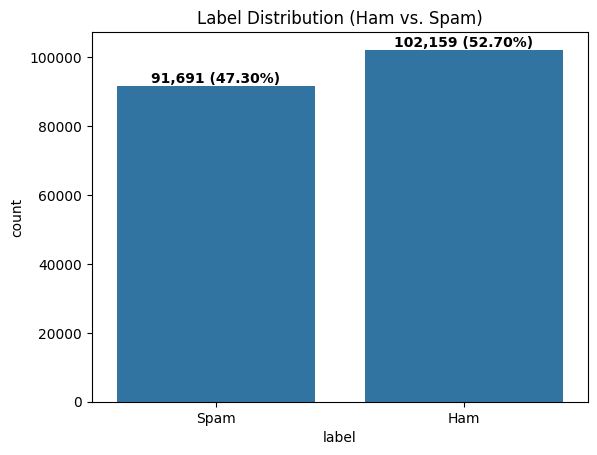

In [11]:
# class distribution analysis (count and percentage)
ax = sns.countplot(data=df, x='label')
plt.title("Label Distribution (Ham vs. Spam)")

total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{count:,} ({percent:.2f}%)',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.show()

*The plot shows that Spam constitutes 47.30% (91,691 emails) and Ham constitutes 52.70% (102,159 emails) of the dataset after cleaning*

**Data Preprocessing**

*The preprocess_text function cleans the email text data:*
*   *Removes non-alphanumeric characters*
*   *Converts text to lowercase*
*   *Removes extra whitespace and stripping leading/trailing whitespace*

*The preprocess_text function is applied to the 'text' column and stores the result in a new column - 'cleaned_text'*

*LabelEncoder transforms the categorical 'label' column ('Ham', 'Spam') into numerical values (0 for 'Ham', 1 for 'Spam'). The original 'label' column is overwritten with these numerical labels*

In [16]:
def preprocess_text(text):
    """Clean and standardize email text"""
    text = re.sub(r'\W', ' ', str(text))  # remove non-alphanumeric
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

# apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# encode labels (Ham:0, Spam:1)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [18]:
df.head()

,label,text,cleaned_text
0,1,viiiiiiagraaaa\nonly for the ones that want to...,viiiiiiagraaaa only for the ones that want to ...
1,0,got ice thought look az original message ice o...,got ice thought look az original message ice o...
2,1,yo ur wom an ne eds an escapenumber in ch ma n...,yo ur wom an ne eds an escapenumber in ch ma n...
3,1,start increasing your odds of success & live s...,start increasing your odds of success live sex...
4,0,author jra date escapenumber escapenumber esca...,author jra date escapenumber escapenumber esca...


**Feature Engineering & Data Splitting**

*Dataset is separated into features X (the 'cleaned_text' column) and the target variable y (the numerically encoded 'label' column)*

*train_test_split method used to divide the data into training (80%) and testing (20%) sets. random_state=42 ensures reproducibility, and stratify=y maintains the original proportion of 'Ham' and 'Spam' labels in both sets*

*TfidfVectorizer converts the text data into numerical features using the TF-IDF (Term Frequency-Inverse Document Frequency) method:*
* *max_features=5000: Limits the vocabulary to the top 5000 most frequent terms*
* *stop_words='english': Removes common English stop words*

*Fits the vectorizer on the training text (X_train) and transforms both X_train and X_test into TF-IDF matrices (X_train_tfidf, X_test_tfidf)*

In [17]:
# Split data into features and target
X = df['cleaned_text']
y = df['label']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**Model Training**

*Initializes the Logistic Regression classifier and trains it using the TF-IDF features from the training set (X_train_tfidf) and the corresponding training labels (y_train).*
*   *max_iter=1000: Increases the maximum number of iterations allowed for the solver to converge, which can be helpful for larger datasets.*
*   *random_state=42: Ensures reproducibility of the results.*

In [19]:
# Initialize and train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

**Visualization of Logistic Regression Outputs**

*Calculates the linear output z (log-odds/logit) for each sample in the training set using the trained model's decision_function() method on the training TF-IDF features (X_train_tfidf)*


In [21]:
z = model.decision_function(X_train_tfidf)
z

array([ 1.84725522,  1.22914531, -7.96937111, ...,  3.73380246,
        5.59539606,  8.16750985], shape=(155080,))

**Linear Output**

*Creates a scatter plot of these z values against the sample index, coloring the points based on their actual class (y_train). A horizontal dashed line is added at z=0, representing the decision boundary before the sigmoid transformation*

*Creates a scatter plot visualizing the linear separability of the training data. Points (red) above the z=0 line are more likely to be classified as Spam (1), and those (blue) below as Ham (0), based on the linear model*

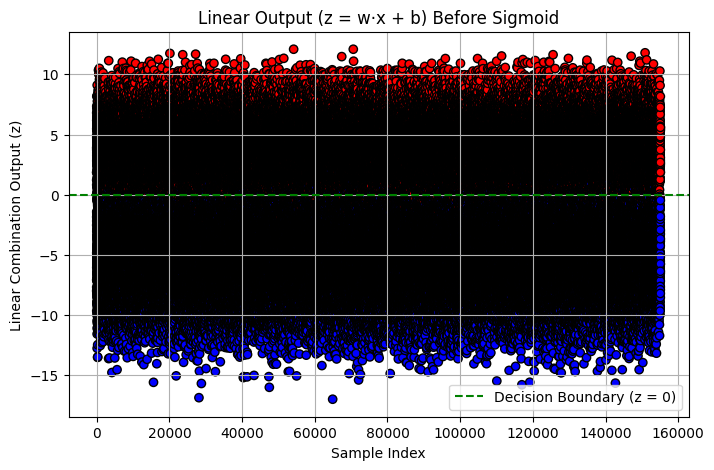

In [22]:
# Plot linear output z = w·x + b
plt.figure(figsize=(8, 5))
plt.scatter(range(len(z)), z, c=y_train, cmap='bwr', edgecolor='k')
plt.axhline(0, color='green', linestyle='--', label='Decision Boundary (z = 0)')
plt.title("Linear Output (z = w·x + b) Before Sigmoid")
plt.xlabel("Sample Index")
plt.ylabel("Linear Combination Output (z)")
plt.grid(True)
plt.legend()
plt.show()

*Calculates the predicted probabilities prob (output of the sigmoid function) for the training set using the trained model's predict_proba() method and selecting the probability for the positive class (Spam, typically class 1). It then plots these probabilities (prob) against the corresponding linear outputs (z calculated in the previous cell), effectively visualizing the sigmoid curve as fitted to this specific dataset. A horizontal dashed line at probability 0.5 represents the classification threshold.*

In [24]:
prob = model.predict_proba(X_train_tfidf)[:, 1]
prob

array([8.63804512e-01, 7.73668949e-01, 3.45776844e-04, ...,
       9.76656181e-01, 9.96298822e-01, 9.99716357e-01], shape=(155080,))

**Sigmoid Curve**

*A scatter plot showing the characteristic 'S' shape of the sigmoid function, mapping the linear outputs (z) to probabilities between 0 and 1*

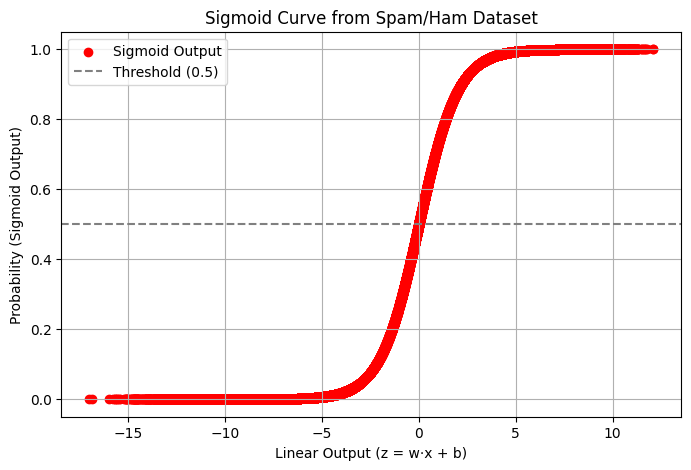

In [25]:
# Plot sigmoid probabilities against z
plt.figure(figsize=(8, 5))
plt.scatter(z, prob, color='red', label='Sigmoid Output')
plt.axhline(0.5, color='grey', linestyle='--', label='Threshold (0.5)')
plt.title("Sigmoid Curve from Spam/Ham Dataset")
plt.xlabel("Linear Output (z = w·x + b)")
plt.ylabel("Probability (Sigmoid Output)")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
# Cross-validation
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Test set evaluation
y_pred = model.predict(X_test_tfidf)

# Performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")


Cross-Validation Accuracy: 0.9721 (±0.0008)

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.97     20432
        Spam       0.97      0.97      0.97     18338

    accuracy                           0.97     38770
   macro avg       0.97      0.97      0.97     38770
weighted avg       0.97      0.97      0.97     38770


Confusion Matrix:
[[19792   640]
 [  504 17834]]

ROC AUC Score: 0.9706
